In [272]:
from typing import List, Tuple, Dict
from itertools import combinations

from qiskit import QuantumCircuit, Aer, execute
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.opflow import X, Y

import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from numba import jit

In [273]:
##########################################
# ---------- HELPER FUNCTIONS ---------- #
##########################################

def string_to_array(string_rep: str) -> np.ndarray:
    return np.array([int(bit) for bit in string_rep]).astype(np.float64)


@jit(nopython=True, cache=True)
def qubo_cost(state: np.ndarray, QUBO_matrix: np.ndarray) -> float:
    return np.dot(state, np.dot(QUBO_matrix, state))


def portfolio_metrics(n: int, seed: int) -> tuple[np.ndarray, np.ndarray]:
    """ Generates random PSD covar matrix and random expected returns vector"""
    np.random.seed(seed)
    _expected_returns_ = np.random.uniform(low=0, high=0.99, size=n)
    _temp_ = np.random.uniform(low=0, high=0.99, size=(n, n))
    _covariances_ = np.dot(_temp_, _temp_.transpose())
    if not np.all(_covariances_ == _covariances_.T) or not np.all(np.linalg.eigvals(_covariances_) >= 0):
        raise ValueError('Covariance matrix is not PSD.')

    return _expected_returns_, _covariances_

def min_cost_partition(nr_qubits: int,
                       k: int,
                       mu: np.ndarray,
                       sigma: np.ndarray,
                       alpha: float) -> Tuple[dict, dict, float]:
    
    def generate_binary_combinations(n: int, k: int) -> np.ndarray:
        """ Generates all the 'n' chose 'k' combinations w. 'k' ones. """
        num_permutations = 2 ** n
        for indices in combinations(range(n), k):
            # Create a numpy array of zeros of size N
            arr = np.zeros(n, dtype=int)
            # Set ones at the specified positions
            arr[list(indices)] = 1
            yield arr

    def generate_binary_permutations(n: int) -> np.ndarray:
        """ Generates all the 2^n permutations of bitstring w. length 'n'. """
        num_permutations = 2 ** n
        for i in range(num_permutations):
            _binary_string_ = bin(i)[2:].zfill(n)
            yield np.array([int(bit) for bit in _binary_string_])

    def cost(state: np.ndarray, mu: np.ndarray, sigma: np.ndarray, alpha: float) -> float:
        return -np.dot(state, mu) + alpha * np.dot(state, np.dot(sigma, state))

    max_cost_1, min_cost_1, min_comb = -np.inf, np.inf, np.empty(shape=(nr_qubits,))
    for comb in generate_binary_combinations(n=nr_qubits, k=k):
        comb_cost = cost(state=comb, mu=mu, sigma=sigma, alpha=alpha)
        if comb_cost < min_cost_1:
            min_cost_1, min_comb = comb_cost, comb
        if comb_cost > max_cost_1:
            max_cost_1 = comb_cost
    binary_comb = min_comb

    max_cost_2, min_cost_2, min_perm = -np.inf, np.inf, np.empty(shape=(nr_qubits,))
    for perm in generate_binary_permutations(n=nr_qubits):
        perm_cost = cost(state=perm, mu=mu, sigma=sigma, alpha=alpha)
        if perm_cost < min_cost_2:
            min_cost_2, min_perm = perm_cost, perm
        if perm_cost > max_cost_2:
            max_cost_2 = perm_cost
    binary_perm = min_perm

    _lmbda_ = 0
    if min_cost_2 < min_cost_1:
        _lmbda_ = abs(min_cost_2) - abs(min_cost_1)

    _constrained_result_ = {'s': binary_comb, 'c_min': min_cost_1, 'c_max': max_cost_1}
    _full_result_        = {'s': binary_perm, 'c_min': min_cost_2, 'c_max': max_cost_2}
    return _constrained_result_, _full_result_, _lmbda_


def get_qubo(mu: np.ndarray, sigma: np.ndarray, alpha: float, lmbda: float, k: float):
    """Generates the QUBO for the portfolio objective: s^T*mu + alpha*(s^T*Covar*s) """
    Q = np.zeros_like(sigma)
    N = Q.shape[0]
    for i in range(N):
        for j in range(N):
            if i == j:
                Q[i, j] += -mu[i] - 2 * k * lmbda + lmbda + alpha * sigma[i, j]
            else:
                Q[i, j] += lmbda + alpha * sigma[i, j]
    offset = lmbda * k ** 2
    return Q, offset

def normalized_cost(result: Dict[str, float],
                    QUBO_matrix: np.ndarray,
                    QUBO_offset,
                    max_cost: float,
                    min_cost: float) -> float:
    best_state = list(result.keys())[np.argmax(list(result.values()))]
    found_cost = qubo_cost(np.array([float(_) for _ in best_state]).astype(np.float64), QUBO_matrix) + QUBO_offset
    return abs(found_cost - min_cost) / abs(max_cost - min_cost)

In [274]:
#################################
# ---------- CLASSES ---------- #
#################################

class Grid:
    def __init__(self,
                 N_qubits: int = None,
                 Rows: int = None,
                 Cols: int = None):

        self.using_N_qubits = False
        if N_qubits is None:
            if Rows is None or Cols is None:
                raise ValueError(
                    'When the grid is not initialized using "N_qubits", it should be initialized, using "Rows" and '
                    '"Cols".')
        else:
            if int(np.sqrt(N_qubits)) - np.sqrt(N_qubits) != 0:
                raise ValueError(
                    f'When grid is initialized w. "N_qubits" it is assumed to be a square grid, and therefore '
                    f'"N_qubits" must be a perfect square integer. ')
            self.N_qubits = N_qubits
            self.using_N_qubits = True
        if Rows is not None or Cols is not None:
            if N_qubits is not None:
                raise ValueError(f'When specifying the grid using "Rows" & "Cols", "N_qubits" should not be specified.')
            if Rows is None or Cols is None:
                raise ValueError(
                    f'When specifying the grid without "N_qubits", both "Rows" & "Cols" has to be specified.')
        else:
            self.rows, self.cols = Rows, Cols

    def get_grid_indexing(self) -> np.ndarray:
        if self.using_N_qubits:
            root = int(np.sqrt(self.N_qubits))
            return np.array([[col + row * root for col in range(root)] for row in range(root)])
        else:
            return np.array([[col + row * self.cols for col in range(self.cols)] for row in range(self.rows)])

    def get_NN_indices(self) -> List[Tuple[int, int]]:
        """ Returns pairs of indices corresponding to
        Nearest Neighbor interactions in the grid structure """
        grid_indices = self.get_grid_indexing()
        rows, cols = grid_indices.shape
        NN_pairs = []
        for row in range(rows):
            for col in range(cols):
                if row == rows - 1:
                    if col < cols - 1:
                        NN_pairs.append((grid_indices[row, col], grid_indices[row, col + 1]))
                elif col == cols - 1:
                    NN_pairs.append((grid_indices[row, col], grid_indices[row + 1, col]))
                else:
                    NN_pairs.append((grid_indices[row, col], grid_indices[row + 1, col]))
                    NN_pairs.append((grid_indices[row, col], grid_indices[row, col + 1]))
        return NN_pairs
    

class CP_QAOA:
    def __init__(self,
                 N_qubits,
                 cardinality,
                 layers,
                 QUBO_matrix,
                 grid = None,
                 with_evenly_distributed_start_x: bool = False,
                 with_next_nearest_neighbors: bool = False):
        
        self.n_qubits = N_qubits
        self.cardinality = cardinality
        self.layers = layers
        self.QUBO_matrix = QUBO_matrix

        self.with_evenly_distributed_start_x = with_evenly_distributed_start_x
        self.with_next_nearest_neighbors = with_next_nearest_neighbors


        if grid is None:
            # Normal 1D chain Nearest Neighbors
            self.nearest_neighbor_pairs = [(i, i+1) for i in range(self.n_qubits-1)]
        else:
            # Grid Nearest Neighbors
            self.nearest_neighbor_pairs = grid.get_NN_indices()

        if self.with_evenly_distributed_start_x:
            # Calculate the step size for distributing X gates
            self.step_size = self.n_qubits / (self.cardinality + 1)

        self.simulator = Aer.get_backend('statevector_simulator')
        
        #print("Using cardinality: ", self.cardinality)
        #print('Initial excitations at: ', [int(self.step_size * i) for i in range(1, self.cardinality+1)])

    def set_circuit(self, angles):

        qcircuit = QuantumCircuit(self.n_qubits)

        # Initial state
        if self.with_evenly_distributed_start_x:
            # Distributing x-gates across string evenly
            for i in range(1, self.cardinality + 1):
                qcircuit.x(int(self.step_size * i))
        else:
            # Setting 'k' first with x-gates
            for qubit_index in range(self.cardinality):
                qcircuit.x(qubit_index)

        NN_angles_per_layer = self.n_qubits - 1
        NNN_angles_per_layer = self.n_qubits - 2
        total_NN_angles = NN_angles_per_layer * self.layers
        for layer in range(self.layers):
            # Nearest Neighbor
            counter = 0
            for (qubit_i, qubit_j) in self.nearest_neighbor_pairs:
                theta_ij = angles[(layer * NN_angles_per_layer) + counter]

                # Define the Hamiltonian for XX and YY interactions
                xx_term = theta_ij * (X ^ X)
                yy_term = theta_ij * (Y ^ Y)
                hamiltonian = xx_term + yy_term

                # Create the time-evolved operator
                time_evolved_operator = PauliEvolutionGate(hamiltonian, time=1.0)
                qcircuit.append(time_evolved_operator, [qubit_i, qubit_j])

                # Increment counter for angles
                counter += 1
                
            # Next Nearest Neighbor
            if self.with_next_nearest_neighbors:
                for qubit_i in range(self.n_qubits - 2):
                    theta_ij = angles[total_NN_angles + (layer * NNN_angles_per_layer) + qubit_i]
                    qubit_j = qubit_i + 2

                    # Define the Hamiltonian for XX and YY interactions
                    xx_term = theta_ij * (X ^ X)
                    yy_term = theta_ij * (Y ^ Y)
                    hamiltonian = xx_term + yy_term

                    # Create the time-evolved operator
                    time_evolved_operator = PauliEvolutionGate(hamiltonian, time=1.0)
                    qcircuit.append(time_evolved_operator, [qubit_i, qubit_j])

        return qcircuit

    def get_cost(self, angles) -> float:
        circuit = self.set_circuit(angles=angles)
        counts = execute(circuit, self.simulator).result().get_counts()
        return np.mean([probability * qubo_cost(state=string_to_array(bitstring), QUBO_matrix=self.QUBO_matrix) for
                        bitstring, probability in counts.items()])

    def get_state_probabilities(self, angles, flip_states: bool = True) -> dict:
        circuit = self.set_circuit(angles=angles)
        counts = execute(circuit, self.simulator).result().get_counts()
        if flip_states:
            return {bitstring[::-1]: probability for bitstring, probability in counts.items()}
        return {bitstring: probability for bitstring, probability in counts.items()}

In [275]:
# Number of Qubits 
N=9
# Number of excitations
k=4
# RNG seed for reproducibility
seed=0
# alpha in: s^T*mu + alpha*(s^T*Covar*s)
alpha=0.1
# Nr. of layer repetitions
layers=2
# Maximal number of iterations for classical solver
max_iter=300

# Using grid Nearest neighbors
w_grid = True
# Using next nearest neighbors (in 1D chain model)
w_next_nearest_neighbors = False
# Distributing the 'k' excitations evenly (instead of just 'k' first)
w_evenly_distributed = True

In [276]:
# Generating grid
if w_grid:
    my_grid = Grid(N_qubits=N)
    print(f' Qubit indices in grid: \n', my_grid.get_grid_indexing())
    print(f'\n Corresponding Nearest Neighbor index pairs: \n', my_grid.get_NN_indices())

 Qubit indices in grid: 
 [[0 1 2]
 [3 4 5]
 [6 7 8]]

 Corresponding Nearest Neighbor index pairs: 
 [(0, 3), (0, 1), (1, 4), (1, 2), (2, 5), (3, 6), (3, 4), (4, 7), (4, 5), (5, 8), (6, 7), (7, 8)]


In [277]:
# Generating random problem instance 
expected_returns, covariances = portfolio_metrics(n=N, seed=seed)

# Retrieving C_min, C_max and corresponding states.
constrained_result, full_result, lmbda = min_cost_partition(nr_qubits=N,
                                                            k=k,
                                                            mu=expected_returns,
                                                            sigma=covariances,
                                                            alpha=alpha)

max_cost, min_cost, min_state = constrained_result['c_max'], constrained_result['c_min'], constrained_result['s']
min_state_str = ''.join([str(_) for _ in min_state])

# Generating QUBO corresponding to current problem instance
Q, offset = get_qubo(mu=expected_returns,
                     sigma=covariances,
                     alpha=alpha,
                     lmbda=lmbda,
                     k=k)
print("Optimal state is: |"+min_state_str+">")

Optimal state is: |000011011>


In [278]:
# Generating instance of ansatz
ansatz = CP_QAOA(N_qubits=N,
                 cardinality=k,
                 layers=layers,
                 grid=my_grid if w_grid else None,
                 QUBO_matrix=Q,
                 with_next_nearest_neighbors=w_next_nearest_neighbors,
                 with_evenly_distributed_start_x=w_evenly_distributed)

In [279]:
# Generating initial guess for rotation angles
theta_min, theta_max = -2*np.pi, 2*np.pi
if w_grid:
    N_angles = layers * len(my_grid.get_NN_indices())
else:
    N_angles = layers * (N - 1) 
if w_next_nearest_neighbors:
    N_angles += layers * (N - 2)
theta_i = np.random.uniform(low=theta_min, high=theta_max, size=N_angles)

# Choosing optimizer for scipy
available_methods = ['COBYLA', 'Nelder-Mead']
optimizer_method = available_methods[0]

# Generating callback function for plotting
costs = [] # Normalized costs
angles = [] # Corresponding rotations angles
best_state_probs = [] # Probability of sampling best state 
def callback_function(x):
    _dict_ = ansatz.get_state_probabilities(angles=x, flip_states=False)
    _cost_ = normalized_cost(result=_dict_,
                             QUBO_matrix=Q,
                             QUBO_offset=offset,
                             max_cost=max_cost, 
                             min_cost=min_cost)
    if min_state_str in list(_dict_.keys()):
        best_state_probs.append(_dict_[min_state_str])
    else:
        best_state_probs.append(0)
    costs.append(_cost_)
    angles.append(x)

# Performing optimization
res = sc.optimize.minimize(fun=ansatz.get_cost, x0=theta_i,
                           method=optimizer_method,
                           options={'disp': False, 'maxiter': max_iter},
                           callback=callback_function)
print(res)

 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -0.08209000816712797
       x: [-1.992e+00  3.133e+00 ...  2.417e+00 -2.580e+00]
    nfev: 300
   maxcv: 0.0


Text(0, 0.5, 'Optimal state probability')

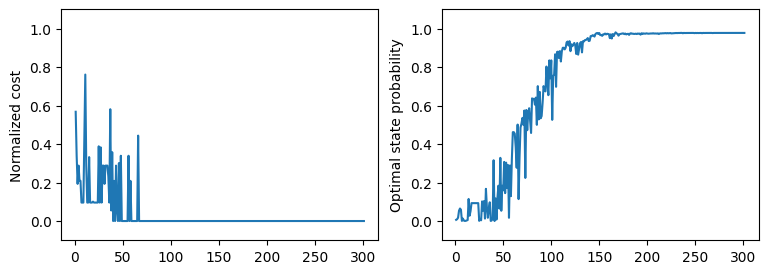

In [280]:
# Plotting results
fig, ax = plt.subplots(1,2,figsize=(9,3))

ax[0].plot([it + 1 for it in range(len(costs))],costs)
ax[0].set_ylim(-0.1,1.1)
ax[0].set_ylabel('Normalized cost')

ax[1].plot([it + 1 for it in range(len(best_state_probs))],best_state_probs)
ax[1].set_ylim(-0.1,1.1)
ax[1].set_ylabel('Optimal state probability')

# Average over multiple instances:

In [281]:
def simulate(datapoint):
    _N_, _K_, _M_, _A_, _S_, _L_, _WG_, _WNNN_, _WED_ = datapoint
    # Generating random problem instance 
    _expected_returns_, _covariances_ = portfolio_metrics(n=_N_, seed=_S_)
    
    # Retrieving C_min, C_max and corresponding states.
    _constrained_result_, _full_result_, _lmbda_ = min_cost_partition(nr_qubits=_N_,
                                                                k=_K_,
                                                                mu=_expected_returns_,
                                                                sigma=_covariances_,
                                                                alpha=_A_)
    
    _max_cost_, _min_cost_, _min_state_ = _constrained_result_['c_max'], _constrained_result_['c_min'], _constrained_result_['s']
    _min_state_str_ = ''.join([str(_) for _ in _min_state_])
    
    # Generating QUBO corresponding to current problem instance
    _Q_, _offset_ = get_qubo(mu=_expected_returns_,
                         sigma=_covariances_,
                         alpha=_A_,
                         lmbda=_lmbda_,
                         k=_K_)
    
    # Generating instance of ansatz
    _ansatz_ = CP_QAOA(N_qubits=_N_,
                       cardinality=_K_,
                       layers=_L_,
                       grid=Grid(N_qubits=_N_) if _WG_ else None,
                       QUBO_matrix=_Q_,
                       with_next_nearest_neighbors=_WNNN_,
                       with_evenly_distributed_start_x=_WED_)
    
    # Generating initial guess for rotation angles
    _theta_min_, _theta_max_ = -2*np.pi, 2*np.pi
    if _WG_:
        _N_angles_ = _L_ * len(Grid(N_qubits=_N_).get_NN_indices())
    else:
        _N_angles_ = _L_ * (_N_ - 1) 
    if _WNNN_:
        _N_angles_ += _L_ * (_N_ - 2)
    _theta_i_ = np.random.uniform(low=_theta_min_, high=_theta_max_, size=_N_angles_)
    
    # Choosing optimizer for scipy
    _available_methods_ = ['COBYLA', 'Nelder-Mead']
    _optimizer_method_ = _available_methods_[0]
    
    # Generating callback function for plotting
    _costs_ = [] # Normalized costs
    _best_state_probs_ = [] # Probability of sampling best state 
    def _callback_function_(x):
        _dict_ = _ansatz_.get_state_probabilities(angles=x, flip_states=False)
        _cost_ = normalized_cost(result=_dict_,
                                 QUBO_matrix=_Q_,
                                 QUBO_offset=_offset_,
                                 max_cost=_max_cost_, 
                                 min_cost=_min_cost_)
        if _min_state_str_ in list(_dict_.keys()):
            _best_state_probs_.append(_dict_[_min_state_str_])
        else:
            _best_state_probs_.append(0)
        _costs_.append(_cost_)
    
    # Performing optimization
    _res_ = sc.optimize.minimize(fun=_ansatz_.get_cost, x0=_theta_i_,
                               method=_optimizer_method_,
                               options={'disp': False, 'maxiter': _M_},
                               callback=_callback_function_)
    
    _type_ = 0 if _WG_ else 1
    return _costs_, _best_state_probs_, _type_


In [282]:
# Generating datapoints
# Nqubits, Cardinality, max iter, alpha, seed, layers, with grid, with next nearest, with evenly distributed
N_OF_EACH = 10
datapoints = []
for seed in range(N_OF_EACH):
    datapoints.append((9,4,200,0.1,seed,2,True,False,True))
for seed in range(N_OF_EACH,2*N_OF_EACH):
    datapoints.append((9,4,200,0.1,seed,2,False,False,True))

In [283]:
from tqdm import tqdm
results = []
for datapoint in tqdm(datapoints):
    results.append(simulate(datapoint))

100%|██████████| 20/20 [03:49<00:00, 11.47s/it]


In [284]:
grid_probs, chain_probs = [], []
grid_costs, chain_costs = [], []
min_N_iterations = min([len(_[0]) for _ in results])
for result in results:
    if len(result[0]) < min_N_iterations:
        min_N_iterations = len(result[0])
    if result[-1] == 0:
        grid_costs.append(result[0][:min_N_iterations])
        grid_probs.append(result[1][:min_N_iterations])
    else:
        chain_costs.append(result[0][:min_N_iterations])
        chain_probs.append(result[1][:min_N_iterations])
grid_probs, chain_probs = np.array(grid_probs), np.array(chain_probs)
grid_costs, chain_costs = np.array(grid_costs), np.array(chain_costs)

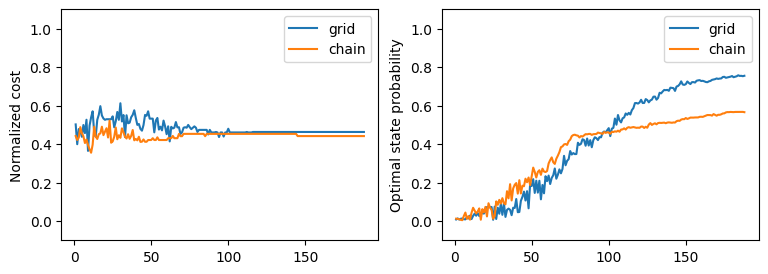

In [285]:
avg_grid_probs, avg_chain_probs = np.mean(grid_probs,axis=0), np.mean(chain_probs,axis=0)
avg_grid_costs, avg_chain_costs = np.mean(grid_costs,axis=0), np.mean(chain_costs,axis=0)

# Plotting results
fig, ax = plt.subplots(1,2,figsize=(9,3))

ax[0].plot([it + 1 for it in range(len(avg_grid_costs))],avg_grid_costs, label='grid')
ax[0].plot([it + 1 for it in range(len(avg_chain_costs))],avg_chain_costs, label='chain')

ax[0].set_ylim(-0.1,1.1)
ax[0].set_ylabel('Normalized cost')
ax[0].legend()

ax[1].plot([it + 1 for it in range(len(avg_grid_probs))],avg_grid_probs, label='grid')
ax[1].plot([it + 1 for it in range(len(avg_chain_probs))],avg_chain_probs, label='chain')

ax[1].set_ylim(-0.1,1.1)
ax[1].set_ylabel('Optimal state probability')
ax[1].legend()